In [1]:
import rasterio
from rasterio.windows import from_bounds
import geopandas as gpd
from shapely.geometry import box

In [2]:
pre_vh_glcm_path="../../Asc_SAR_Data_Processing/11_GLCM/subset_S1A_Asc_Spkleesigma_TC_glcm28dec_vh_32611.tif"
pre_vv_glcm_path="../../Asc_SAR_Data_Processing/11_GLCM/subset_S1A_Asc_Spkleesigma_TC_glcm28dec_vv_32611.tif"
post_vh_glcm_path="../../Asc_SAR_Data_Processing/11_GLCM/subset_S1A_Asc_Spkleesigma_TC_glcm21jan_vh_32611.tif"
post_vv_glcm_path="../../Asc_SAR_Data_Processing/11_GLCM/subset_S1A_Asc_Spkleesigma_TC_glcm21jan_vv_32611.tif"

output_dGLCM_path="input/dGLCM.tif"
output_pca_path="input/dGLCM_pca.tif"


In [3]:
with rasterio.open(pre_vh_glcm_path) as src:
    pre_vh_bands = src.read()  # Read all bands
    meta=src.meta.copy()
    meta.update({"count":20})


with rasterio.open(pre_vv_glcm_path) as src:
    pre_vv_bands = src.read()  # Read all bands

with rasterio.open(post_vh_glcm_path) as src:
    post_vh_bands = src.read()  # Read all bands

with rasterio.open(post_vv_glcm_path) as src:
    post_vv_bands = src.read()  # Read all bands




with rasterio.open(output_dGLCM_path, "w", **meta) as dst:
    for i in range(0,10):
        diff=post_vh_bands[i]-pre_vh_bands[i]
        dst.write(diff,i+1)
    for i in range(0, 10):
        diff = post_vv_bands[i] - pre_vv_bands[i]
        dst.write(diff, i + 11) 
    



Number of principal components selected: 4


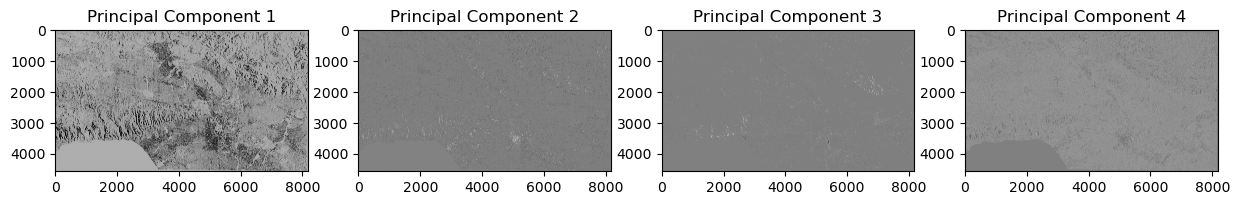

In [4]:
import rasterio
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Load the TIFF image using rasterio
# Replace output_dGLCM_path with the actual path to your image
with rasterio.open(output_dGLCM_path) as src:
    # Read all bands (assuming the image is multi-band)
    bands = src.read()  # Shape will be (bands, height, width)
    meta=src.meta.copy()

# Step 2: Reshape the image data into (height*width, bands)
# Flatten the image into a 2D array where each row represents a pixel, and each column a band
pixels = bands.reshape(bands.shape[0], -1).T  # Transpose to have shape (num_pixels, num_bands)

# Step 3: Apply PCA
pca = PCA(n_components=0.99)  # Get the first 5 principal components
principal_components = pca.fit_transform(pixels)  # Shape will be (num_pixels, 5)

num_components = pca.n_components_
print(f'Number of principal components selected: {num_components}')

# Step 4: Reshape back to the image shape (height, width, 5) for visualization and saving
principal_components_image = principal_components.T.reshape(num_components, bands.shape[1], bands.shape[2])

# Step 5: Plot the first 5 principal components (RGB)
plt.figure(figsize=(15, 15))
for i in range(num_components):
    plt.subplot(1, num_components, i+1)
    plt.imshow(principal_components_image[i], cmap='gray')
    plt.title(f'Principal Component {i+1}')
plt.show()

# Step 6: Save the PCA results to a new TIFF file
meta.update({'count':num_components})

with rasterio.open(output_pca_path, 'w', **meta) as dst:
    # Write each principal component as a separate band
    for i in range(num_components):
        dst.write(principal_components_image[i], i+1)
